In [1]:
from sklearn import preprocessing, metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from copy import deepcopy
import numpy as np
from numpy import newaxis
import struct
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import json
import codecs
# from tqdm.notebook import tqdm
from tqdm import tqdm

np.random.seed(0)


def to_pickle_string(x):
    return codecs.encode(pickle.dumps(x), 'base64').decode()


def from_pickle_string(x):
    return pickle.loads(codecs.decode(x.encode(), "base64"))


class NumpyJSONEncoder(json.JSONEncoder):

    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


def save_numpy(file, x):
    with open(file, 'w') as f:
        json.dump(x, f, cls=NumpyJSONEncoder)


def print_numpy_unscientific(x):
    with np.printoptions(suppress=True):
        print(x)


def show_image(X, y):
    print(y)
    plt.imshow(X, cmap='gray' if X.shape[2] == 1 else None)


def one_hot(y, n_values):
    return np.eye(n_values)[y.flatten()]


def reverse_one_hot(y):
    return np.argmax(y, axis=-1)


<h1 id="dataset" style="color:white; background:black; border:1px dashed;"> 
    <center>Loading dataset
        <a class="anchor-link" href="#dataset" target="_self">¶</a>
    </center>
</h1>

In [2]:
def check_data(X, y):
    assert len(X) == len(y)
    rand_idx = np.random.choice(len(y))
    show_image(X[rand_idx], y[rand_idx])
    sns.countplot(x=reverse_one_hot(y))


### CIFAR-10

In [3]:
cifar_path = "/kaggle/input/cifar10-python/cifar-10-batches-py/"


def unpickle(file, encoding='bytes'):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding=encoding)
    return dict


def cifar_read(file):
    data = unpickle(cifar_path + file)
    return data[b'data'].reshape((10000, 3, 32, 32)).transpose(
        (0, 2, 3, 1)) / 255, one_hot(np.array(data[b'labels']), 10)


X_train, y_train = (np.concatenate(x) for x in zip(
    *[cifar_read(f"data_batch_{i}") for i in range(1, 6)]))
# check_data(X_train, y_train)

X_test, y_test = cifar_read("test_batch")
# check_data(X_test, y_test)

cifar_classes = unpickle(cifar_path + "batches.meta", 'ascii')
cifar_classes


{'num_cases_per_batch': 10000,
 'label_names': ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'],
 'num_vis': 3072}

## Splitting test and validation set

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


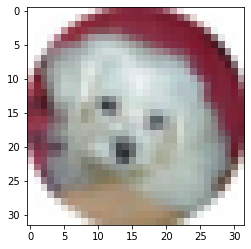

In [4]:
X_validate, X_test, y_validate, y_test = train_test_split(X_test,
                                                          y_test,
                                                          test_size=.5,
                                                          random_state=1)
show_image(X_validate[0], y_validate[0])

<h1 id="implementation" style="color:white; background:black; border:1px dashed;"> 
    <center>Implementation
        <a class="anchor-link" href="#implementation" target="_self">¶</a>
    </center>
</h1>

In [5]:
class Layer:
    cache_X = None
    learn_rate = 0.001

    def forward(self, X):
        self.cache_X = X.copy()

    def backward(self, grad_in):
        raise NotImplementedError


def generate_regions(X, dim, stride):
    assert X.shape[1] >= dim
    assert X.shape[2] >= dim
    # X is of shape (batch_size, height, width, in_nchannel)
    for fh, h in enumerate(range(0, X.shape[1] - dim + 1, stride)):
        for fw, w in enumerate(range(0, X.shape[2] - dim + 1, stride)):
            yield fh, fw, np.s_[:, h:h + dim, w:w + dim, :]


class Conv2D(Layer):
    W = None
    b = None
    out_nchannel = 0
    dim = 0
    stride = 0
    pad = 0

    def __init__(self, out_nchannel, dim, stride, pad):
        self.out_nchannel = out_nchannel
        self.dim = dim
        self.stride = stride
        self.pad = pad
        self.b = np.zeros(self.out_nchannel)

    def forward(self, X):
        # X is of shape (batch_size, height, width, in_nchannel)
        super().forward(X)
        out_nchannel, dim, stride, pad = self.out_nchannel, self.dim, self.stride, self.pad
        if self.W is None:
            self.W = np.random.randn(
                dim, dim, X.shape[-1], out_nchannel) * np.sqrt(
                    2 / (X.shape[1] * X.shape[2] * X.shape[3]))
        W, b = self.W, self.b

        X = np.pad(X, ((0, ), (pad, ), (pad, ), (0, )))
        WX = np.zeros((len(X), (X.shape[1] - W.shape[0]) // stride + 1,
                       (X.shape[2] - W.shape[1]) // stride + 1, out_nchannel))

        for fh, fw, slice in generate_regions(X, dim, stride):
            WX[:, fh, fw, :] = np.tensordot(X[slice], W, axes=3)
        return WX + b

    def backward(self, grad_in):
        X = self.cache_X
        dX = np.zeros_like(X, dtype=float)
        dW = np.zeros_like(self.W)
        db = np.zeros_like(self.b)
        dim, stride, pad = self.dim, self.stride, self.pad
        X = np.pad(X, ((0, ), (pad, ), (pad, ), (0, )))
        dX_pad = np.zeros_like(X, dtype=float)

        for fh, fw, slice in generate_regions(X, dim, stride):
            grad_in_slice = grad_in[:, fh, fw, newaxis, newaxis, newaxis, :]
            dX_pad[slice] += np.sum(self.W * grad_in_slice, axis=-1)
            dW += np.sum(X[slice][..., newaxis] * grad_in_slice, axis=0)
            db += np.sum(grad_in_slice, axis=0).squeeze()
        dX = dX_pad[:, pad:-pad, pad:-pad, :] if pad > 0 else dX_pad
        # assert dW.shape == self.W.shape, dW.shape
        # assert db.shape == self.b.shape, db.shape
        self.W -= dW * self.learn_rate
        self.b -= db * self.learn_rate
        # print('dW mean=', np.mean(dW), '\ndb mean=', np.mean(db))
        return dX


class ReLU(Layer):

    def forward(self, X):
        super().forward(X)
        return np.maximum(X, 0)

    def backward(self, grad_in):
        dX = grad_in.copy()
        dX[self.cache_X <= 0] = 0
        return dX


class MaxPool2D(Layer):
    dim = 0
    stride = 0

    def __init__(self, dim, stride):
        self.dim = dim
        self.stride = stride

    def forward(self, X):
        # X is of shape (batch_size, height, width, in_nchannel)
        super().forward(X)
        dim, stride = self.dim, self.stride
        out_shape = ((X.shape[1] - dim) // stride + 1,
                     (X.shape[2] - dim) // stride + 1, X.shape[3])
        y = np.zeros((len(X), ) + out_shape)
        for fh, fw, slice in generate_regions(X, dim, stride):
            y[:, fh, fw, :] = np.max(X[slice], axis=(1, 2))
        return y

    def backward(self, grad_in):
        X = self.cache_X
        dim, stride = self.dim, self.stride
        dX = np.zeros_like(X, dtype=float)
        for fh, fw, slice in generate_regions(X, dim, stride):
            ## In case of multiple maximum, I first tried propagating to every max, which resulted in exploding / vanishing gradient in CIFAR-10
            ## This problem took me 2 days to debug :)
            xs = X[slice]
            indices = np.indices((xs.shape[0], xs.shape[-1]))
            max_indices = (indices[0], ) + np.unravel_index(
                xs.reshape((xs.shape[0], -1, xs.shape[-1])).argmax(axis=1),
                xs.shape[1:-1]) + (indices[1], )
            mask = np.zeros_like(xs)
            mask[max_indices] = 1
            dX[slice] += mask * grad_in[:, fh, newaxis, fw, newaxis, :]
        return dX


class Flatten(Layer):

    def forward(self, X):
        # X is of shape (batch_size, height, width, in_nchannel)
        # output is of shape (batch_size, -1)
        super().forward(X)
        return X.reshape((len(X), -1))

    def backward(self, grad_in):
        return grad_in.reshape(self.cache_X.shape)


class Dense(Layer):
    W = None
    b = None
    out_dim = 0

    def __init__(self, out_dim):
        self.out_dim = out_dim
        self.b = np.zeros(out_dim)

    def forward(self, X):
        # X is of shape (batch_size, in_dim)
        # output is of shape (batch_size, out_dim)
        super().forward(X)
        in_dim = X.shape[-1]
        if self.W is None:
            self.W = np.random.randn(in_dim, self.out_dim) * np.sqrt(
                2 / in_dim)
        return X @ self.W + self.b

    def backward(self, grad_in):
        X = self.cache_X
        dX = grad_in @ self.W.T
        dW = X.T @ grad_in
        db = np.sum(grad_in, axis=0)
        # assert dW.shape == self.W.shape, dW.shape
        # assert db.shape == self.b.shape, db.shape
        self.W -= dW * self.learn_rate
        self.b -= db * self.learn_rate
        # print('dW mean=', np.mean(dW), '\ndb mean=', np.mean(db))
        return dX


def softmax(X, axis=-1, epsilon=1e-9):
    # actual softmax function is np.exp(X)/np.exp(X).sum(), here same value is calculated in a different way
    # -np.max(X) is used to avoid dividing large numbers which is numerically unstable: https://cs231n.github.io/linear-classify/#softmax
    e_x = np.exp(X - np.max(X, axis=axis, keepdims=True))
    probs = e_x / e_x.sum(axis=axis, keepdims=True)
    # return preprocessing.normalize(probs + epsilon, norm='l1')
    return probs


class SoftmaxCrossEntropy(Layer):
    cache_grad = None

    def forward(self, X, y):
        # X, y and y_hat are of shape (batch_size, in_dim)
        super().forward(X)
        m = len(X)
        y_hat = softmax(X)
        loss = (-1 / m) * np.log(y_hat[y == 1]).sum()
        self.cache_grad = (y_hat - y) / m
        return y_hat, loss

    def backward(self, grad_in):
        return self.cache_grad


In [6]:
class Model:
    layers = []
    learn_rate = 0

    def __init__(self, layers, learn_rate=0.001):
        for layer in layers:
            layer.learn_rate = learn_rate
        self.layers = layers
        self.learn_rate = learn_rate

    def forward(self, X, y=None):
        m = len(X)
        for layer in self.layers[:-1]:
            X = layer.forward(X)
        if y is None:
            return softmax(X)
        assert len(y) == m
        y_hat, loss = self.layers[-1].forward(X, y)
        return y_hat, loss

    def backward(self):
        grad = 1
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad

    def fit(self,
            X_train,
            y_train,
            X_validate,
            y_validate,
            epochs=1,
            batch_size=32):
        n_sample = len(X_train)
        n_batch = (n_sample - 1) // batch_size + 1
        y_pred = np.zeros_like(y_train)
        for epoch in range(epochs):
            print(f"Epoch {epoch+1} ================")
            with tqdm(total=n_batch) as t:
                tot_loss = tot_acc = 0
                for i in range(n_batch):
                    batch = range(batch_size * i,
                                  min(batch_size * (i + 1), n_sample))

                    y_hat, loss = self.forward(X_train[batch], y_train[batch])
                    acc = (1 / len(batch)) * np.sum(
                        reverse_one_hot(y_hat) == reverse_one_hot(
                            y_train[batch]))
                    y_pred[batch] = y_hat

                    grad = self.backward()

                    tot_loss += loss
                    tot_acc += acc
                    if (i + 1) % 32 == 0 or i + 1 == n_batch:
                        t.set_postfix({
                            'avg_loss': tot_loss / (i + 1),
                            'avg_accuracy': tot_acc / (i + 1),
                            'max_abs_gradient': np.max(abs(grad))
                        })
                        cur_n_batch = i % 32 + 1
                        t.update(cur_n_batch)
            print("Validation:")
            val_y_hat, val_loss = self.evaluate(X_validate, y_validate)
            print('loss: ', val_loss)
            print(
                metrics.classification_report(reverse_one_hot(val_y_hat),
                                              reverse_one_hot(y_validate)))

    def predict(self, X, batch_size=32):
        y_pred = []
        n_sample = len(X)
        n_batch = (n_sample - 1) // batch_size + 1
        for i in tqdm(range(n_batch)):
            batch = range(batch_size * i, min(batch_size * (i + 1), n_sample))
            y_hat = self.forward(X[batch])
            y_pred.append(y_hat)
        return np.concatenate(y_pred)

    def evaluate(self, X, y, batch_size=32):
        y_pred = []
        n_sample = len(X)
        n_batch = (n_sample - 1) // batch_size + 1
        tot_loss = 0
        for i in tqdm(range(n_batch)):
            batch = range(batch_size * i, min(batch_size * (i + 1), n_sample))
            y_hat, loss = self.forward(X[batch], y[batch])
            y_pred.append(y_hat)
            tot_loss += loss
        return np.concatenate(y_pred), tot_loss / n_batch

    def get_weights(self):
        weights = []
        for layer in self.layers:
            if hasattr(layer, 'W'):
                weights.append(layer.W)
            if hasattr(layer, 'b'):
                weights.append(layer.b)
        return weights

    def set_weights(self, weights):
        # careful of not copying by reference
        weight_iter = iter(weights)
        for layer in self.layers:
            if hasattr(layer, 'W'):
                layer.W = np.array(next(weight_iter))
            if hasattr(layer, 'b'):
                layer.b = np.array(next(weight_iter))


<h1 id="model" style="color:white; background:black; border:1px dashed;"> 
    <center>Create model
        <a class="anchor-link" href="#model" target="_self">¶</a>
    </center>
</h1>

#### Lenet-5

In [7]:
np.random.seed(0)   ## to get deterministic weights

model = Model([
    Conv2D(6, 5, 1, 0),
    ReLU(),
    MaxPool2D(2, 2),
    Conv2D(16, 5, 1, 0),
    ReLU(),
    MaxPool2D(2, 2),
    Flatten(),
    Dense(120),
    Dense(84),
    Dense(10),
    SoftmaxCrossEntropy()
],
              learn_rate=0.02)

# model.predict(X_train[0:1]) ## to initialize the weights
# model.get_weights()[0][0][0][0]


<h1 id="training" style="color:white; background:black; border:1px dashed;"> 
    <center>Training
        <a class="anchor-link" href="#training" target="_self">¶</a>
    </center>
</h1>

In [8]:
model.fit(X_train, y_train, X_validate, y_validate, epochs=10)

Epoch 1 ================


100%|██████████| 1563/1563 [07:36<00:00,  3.42it/s, avg_loss=1.94, avg_accuracy=0.288, max_abs_gradient=0.0165]


Validation:


100%|██████████| 157/157 [00:10<00:00, 15.01it/s]


loss:  1.6212253449338534
              precision    recall  f1-score   support

           0       0.41      0.56      0.47       345
           1       0.75      0.43      0.55       885
           2       0.15      0.36      0.21       206
           3       0.25      0.29      0.27       436
           4       0.42      0.32      0.36       624
           5       0.18      0.56      0.27       162
           6       0.57      0.38      0.46       737
           7       0.54      0.34      0.42       819
           8       0.45      0.61      0.51       370
           9       0.37      0.45      0.41       416

    accuracy                           0.41      5000
   macro avg       0.41      0.43      0.39      5000
weighted avg       0.48      0.41      0.42      5000

Epoch 2 ================


100%|██████████| 1563/1563 [07:37<00:00,  3.41it/s, avg_loss=1.57, avg_accuracy=0.436, max_abs_gradient=0.0215]


Validation:


100%|██████████| 157/157 [00:11<00:00, 14.10it/s]


loss:  1.4850256238756507
              precision    recall  f1-score   support

           0       0.47      0.53      0.50       421
           1       0.77      0.47      0.58       832
           2       0.25      0.41      0.31       314
           3       0.25      0.32      0.28       396
           4       0.41      0.42      0.42       464
           5       0.30      0.53      0.39       294
           6       0.53      0.49      0.51       532
           7       0.58      0.45      0.51       662
           8       0.65      0.58      0.62       556
           9       0.48      0.46      0.47       529

    accuracy                           0.47      5000
   macro avg       0.47      0.47      0.46      5000
weighted avg       0.51      0.47      0.48      5000

Epoch 3 ================


100%|██████████| 1563/1563 [07:53<00:00,  3.30it/s, avg_loss=1.45, avg_accuracy=0.48, max_abs_gradient=0.0237]


Validation:


100%|██████████| 157/157 [00:11<00:00, 13.65it/s]


loss:  1.404963788577043
              precision    recall  f1-score   support

           0       0.52      0.54      0.53       463
           1       0.74      0.52      0.61       723
           2       0.29      0.44      0.35       344
           3       0.32      0.36      0.34       449
           4       0.49      0.45      0.47       515
           5       0.30      0.50      0.38       304
           6       0.55      0.54      0.54       507
           7       0.60      0.49      0.54       636
           8       0.65      0.59      0.62       549
           9       0.53      0.52      0.53       510

    accuracy                           0.50      5000
   macro avg       0.50      0.49      0.49      5000
weighted avg       0.53      0.50      0.51      5000

Epoch 4 ================


100%|██████████| 1563/1563 [07:46<00:00,  3.35it/s, avg_loss=1.39, avg_accuracy=0.503, max_abs_gradient=0.0302]


Validation:


100%|██████████| 157/157 [00:11<00:00, 14.21it/s]


loss:  1.3724662843250874
              precision    recall  f1-score   support

           0       0.54      0.54      0.54       478
           1       0.73      0.55      0.63       681
           2       0.33      0.45      0.38       374
           3       0.38      0.36      0.37       540
           4       0.51      0.46      0.48       521
           5       0.31      0.49      0.38       318
           6       0.46      0.62      0.53       372
           7       0.62      0.52      0.56       613
           8       0.73      0.55      0.63       662
           9       0.50      0.57      0.53       441

    accuracy                           0.51      5000
   macro avg       0.51      0.51      0.50      5000
weighted avg       0.54      0.51      0.52      5000

Epoch 5 ================


100%|██████████| 1563/1563 [07:37<00:00,  3.41it/s, avg_loss=1.35, avg_accuracy=0.52, max_abs_gradient=0.0375]


Validation:


100%|██████████| 157/157 [00:11<00:00, 14.13it/s]


loss:  1.3315155277739816
              precision    recall  f1-score   support

           0       0.54      0.57      0.56       447
           1       0.72      0.57      0.64       650
           2       0.30      0.48      0.37       321
           3       0.40      0.37      0.38       553
           4       0.51      0.46      0.48       522
           5       0.34      0.49      0.40       355
           6       0.51      0.59      0.55       425
           7       0.66      0.51      0.57       674
           8       0.71      0.61      0.65       581
           9       0.55      0.59      0.57       472

    accuracy                           0.52      5000
   macro avg       0.52      0.52      0.52      5000
weighted avg       0.55      0.52      0.53      5000

Epoch 6 ================


100%|██████████| 1563/1563 [07:36<00:00,  3.43it/s, avg_loss=1.32, avg_accuracy=0.53, max_abs_gradient=0.0409]


Validation:


100%|██████████| 157/157 [00:10<00:00, 14.78it/s]


loss:  1.3163526905630416
              precision    recall  f1-score   support

           0       0.54      0.59      0.56       431
           1       0.74      0.57      0.65       660
           2       0.32      0.49      0.39       337
           3       0.38      0.37      0.38       519
           4       0.50      0.46      0.48       514
           5       0.33      0.49      0.39       340
           6       0.54      0.61      0.57       438
           7       0.67      0.51      0.58       678
           8       0.74      0.59      0.65       629
           9       0.53      0.60      0.56       454

    accuracy                           0.53      5000
   macro avg       0.53      0.53      0.52      5000
weighted avg       0.56      0.53      0.54      5000

Epoch 7 ================


100%|██████████| 1563/1563 [07:36<00:00,  3.42it/s, avg_loss=1.3, avg_accuracy=0.538, max_abs_gradient=0.0427]


Validation:


100%|██████████| 157/157 [00:10<00:00, 14.91it/s]


loss:  1.3035658692860705
              precision    recall  f1-score   support

           0       0.54      0.61      0.57       422
           1       0.74      0.58      0.65       655
           2       0.34      0.48      0.40       366
           3       0.36      0.38      0.37       483
           4       0.51      0.46      0.48       524
           5       0.31      0.53      0.39       298
           6       0.57      0.60      0.58       474
           7       0.69      0.51      0.59       696
           8       0.74      0.60      0.66       612
           9       0.56      0.61      0.58       470

    accuracy                           0.54      5000
   macro avg       0.54      0.54      0.53      5000
weighted avg       0.57      0.54      0.55      5000

Epoch 8 ================


100%|██████████| 1563/1563 [07:35<00:00,  3.43it/s, avg_loss=1.29, avg_accuracy=0.544, max_abs_gradient=0.0467]


Validation:


100%|██████████| 157/157 [00:11<00:00, 14.08it/s]


loss:  1.2959743071104413
              precision    recall  f1-score   support

           0       0.55      0.62      0.58       418
           1       0.73      0.59      0.66       627
           2       0.35      0.48      0.41       370
           3       0.38      0.38      0.38       514
           4       0.50      0.47      0.49       503
           5       0.33      0.52      0.41       328
           6       0.54      0.60      0.57       446
           7       0.70      0.52      0.60       689
           8       0.76      0.60      0.67       631
           9       0.56      0.60      0.58       474

    accuracy                           0.54      5000
   macro avg       0.54      0.54      0.53      5000
weighted avg       0.57      0.54      0.55      5000

Epoch 9 ================


100%|██████████| 1563/1563 [07:36<00:00,  3.43it/s, avg_loss=1.28, avg_accuracy=0.55, max_abs_gradient=0.0457]


Validation:


100%|██████████| 157/157 [00:10<00:00, 14.73it/s]


loss:  1.2934805732096712
              precision    recall  f1-score   support

           0       0.55      0.59      0.57       441
           1       0.73      0.59      0.65       628
           2       0.38      0.50      0.43       383
           3       0.39      0.36      0.38       540
           4       0.49      0.49      0.49       464
           5       0.36      0.53      0.42       346
           6       0.53      0.63      0.58       416
           7       0.69      0.54      0.61       660
           8       0.76      0.59      0.66       649
           9       0.56      0.60      0.58       473

    accuracy                           0.54      5000
   macro avg       0.54      0.54      0.54      5000
weighted avg       0.57      0.54      0.55      5000

Epoch 10 ================


100%|██████████| 1563/1563 [07:36<00:00,  3.42it/s, avg_loss=1.27, avg_accuracy=0.555, max_abs_gradient=0.048]


Validation:


100%|██████████| 157/157 [00:10<00:00, 14.39it/s]


loss:  1.2946060860075652
              precision    recall  f1-score   support

           0       0.55      0.59      0.57       439
           1       0.74      0.57      0.64       664
           2       0.37      0.49      0.42       386
           3       0.38      0.37      0.37       521
           4       0.47      0.52      0.49       431
           5       0.36      0.53      0.43       350
           6       0.56      0.64      0.60       432
           7       0.69      0.55      0.61       650
           8       0.76      0.58      0.66       653
           9       0.54      0.58      0.56       474

    accuracy                           0.54      5000
   macro avg       0.54      0.54      0.54      5000
weighted avg       0.57      0.54      0.55      5000



### Saving trained weights

In [9]:
# save_numpy('weights.txt', model.get_weights())

### Loading trained weights

In [10]:
# with open('weights.txt', 'r') as f:
#     weights = json.load(f)
#     model.set_weights(weights)


<h1 id="testing" style="color:white; background:black; border:1px dashed;"> 
    <center>Testing
        <a class="anchor-link" href="#testing" target="_self">¶</a>
    </center>
</h1>

In [11]:
y_pred, test_loss = model.evaluate(X_test, y_test)
print('Test\nloss: ', test_loss)
print(
    metrics.classification_report(reverse_one_hot(y_pred),
                                  reverse_one_hot(y_test)))


100%|██████████| 157/157 [00:10<00:00, 14.54it/s]

Test
loss:  1.3044919386842555
              precision    recall  f1-score   support

           0       0.54      0.58      0.56       493
           1       0.77      0.59      0.67       640
           2       0.34      0.44      0.38       376
           3       0.40      0.40      0.40       491
           4       0.47      0.55      0.51       453
           5       0.36      0.53      0.43       327
           6       0.57      0.66      0.61       438
           7       0.64      0.49      0.55       639
           8       0.74      0.56      0.64       659
           9       0.57      0.58      0.58       484

    accuracy                           0.54      5000
   macro avg       0.54      0.54      0.53      5000
weighted avg       0.57      0.54      0.55      5000



7


100%|██████████| 1/1 [00:00<00:00, 35.74it/s]

[[0.         0.00464075]
 [1.         0.01189643]
 [2.         0.12057809]
 [3.         0.19040539]
 [4.         0.34299715]
 [5.         0.11351593]
 [6.         0.09405317]
 [7.         0.07393958]
 [8.         0.03777213]
 [9.         0.01020138]]


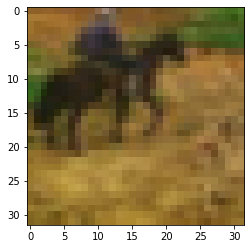

In [12]:
rand_idx = np.random.choice(len(X_test))
label = reverse_one_hot(y_test[rand_idx])
show_image(X_test[rand_idx], label)
batch = range(rand_idx, rand_idx + 1)
y_hat = model.predict(X_test[batch])
print_numpy_unscientific(np.array(list(enumerate(y_hat.squeeze()))))